In [1]:
from datasets import load_dataset

dataset = load_dataset("neuralcatcher/hateful_memes", split="train[:1000]")  # usamos un subset pequeño

Repo card metadata block was not found. Setting CardData to empty.


In [20]:
from huggingface_hub import snapshot_download
local_dir = "/data/cristian/projects/hateful_memes"
repo_id   = "neuralcatcher/hateful_memes"
snapshot_download(repo_id=repo_id,local_dir=local_dir,repo_type="dataset")

(Dataset({
     features: ['id', 'img', 'label', 'text'],
     num_rows: 1000
 }),
 'img/42953.png')

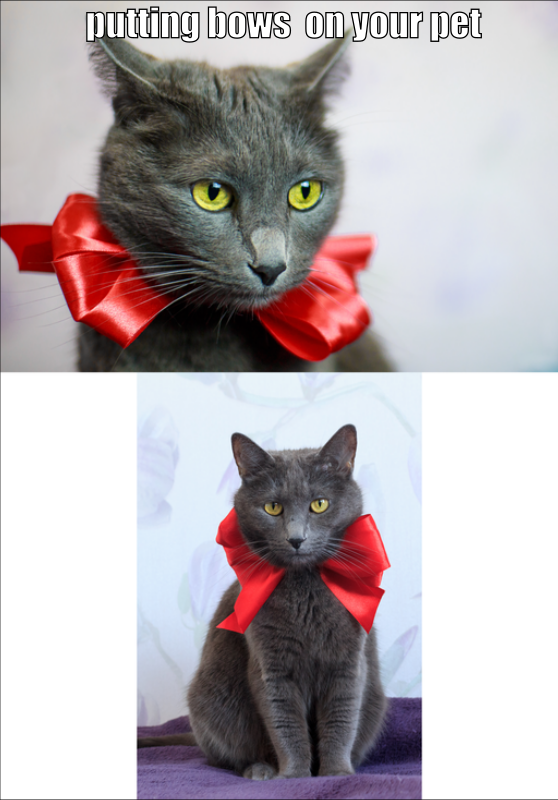

In [37]:
import os
from PIL import Image

image = Image.open(os.path.join("/data/cristian/projects/hateful_memes",dataset[2]["img"]))
image

In [38]:
import torch
from torch import nn
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from PIL import Image
from datasets import load_dataset

# Preprocesamiento
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Modelo multimodal
class MultimodalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = models.resnet18(pretrained=True)
        self.vision_model.fc = nn.Identity()  # sacamos capa final (output: 512)

        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        self.text_proj = nn.Linear(768, 512)

        self.classifier = nn.Sequential(
            nn.Linear(512 + 512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.vision_model(image)
        text_out = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_feat = self.text_proj(text_out.pooler_output)
        x = torch.cat((img_feat, text_feat), dim=1)
        return self.classifier(x)


In [39]:
#!pip install --upgrade torch
#!pip install --upgrade transformers

In [76]:
from torch.utils.data import Dataset, DataLoader
import os

class MemeDataset(Dataset):
    def __init__(self, dataset, base_path):
        self.base_path = base_path
        self.valid_items = [item for item in dataset if os.path.exists(os.path.join(base_path, item["img"]))]

    def __getitem__(self, idx):
        item = self.valid_items[idx]
        image = transform(Image.open(os.path.join(self.base_path, item["img"])).convert("RGB"))
        text  = item["text"]
        encoding = tokenizer(item["text"], padding="max_length", truncation=True, max_length=32, return_tensors="pt")
        label = torch.tensor(item["label"], dtype=torch.float)
        return {
            "image": image,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": label,
            "text":text,
        }

    def __len__(self):
        return len(self.valid_items)


In [59]:

# Carga dataset y modelo
dataset = load_dataset("neuralcatcher/hateful_memes", split="train[:1000]")
dataloader = DataLoader(MemeDataset(dataset,"/data/cristian/projects/hateful_memes"), batch_size=8, shuffle=True)
model = MultimodalClassifier().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

# Entrenamiento
for epoch in range(3):
    model.train()
    for batch in dataloader:
        image = batch["image"].cuda()
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        label = batch["label"].unsqueeze(1).cuda()

        pred = model(image, input_ids, attention_mask)
        loss = loss_fn(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1} | Loss: {loss.item():.4f}")


Repo card metadata block was not found. Setting CardData to empty.


Epoch 1 | Loss: 0.8156
Epoch 2 | Loss: 0.9798
Epoch 3 | Loss: 0.0422


In [72]:
#!ls "/data/cristian/projects/hateful_memes/img/10538.png"

In [73]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_prediction(model, dataset, idx, threshold=0.5):
    model.eval()
    item = dataset[idx]
    
    # Prepara batch (añade dimensión batch)
    image = item["image"].unsqueeze(0).to(device)
    input_ids = item["input_ids"].unsqueeze(0).to(device)
    attention_mask = item["attention_mask"].unsqueeze(0).to(device)
    label = item["label"].item()

    # Predicción
    with torch.no_grad():
        output = model(image, input_ids, attention_mask)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= threshold)

    # Visualización
    image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    plt.imshow(image_np)
    plt.axis("off")
    title = f"GT: {int(label)} | Pred: {pred_label} ({prob:.2f})"
    plt.title(title, fontsize=12)
    plt.show()

    # Mostrar texto
    print(f"📝 Text: {item['text']}")


In [77]:
dataset_val = load_dataset("neuralcatcher/hateful_memes", split="test")
#dataloader = DataLoader(MemeDataset(dataset,"/data/cristian/projects/hateful_memes"), batch_size=8, shuffle=True)

val_dataset = MemeDataset(dataset_val, "/data/cristian/projects/hateful_memes")

Repo card metadata block was not found. Setting CardData to empty.


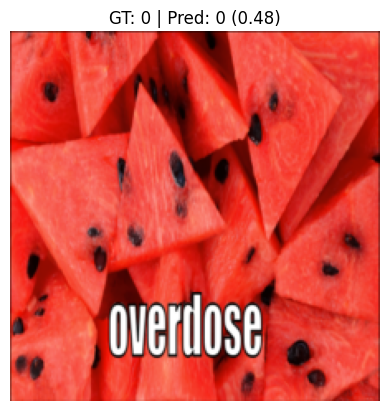

📝 Text: overdose


In [85]:
import torch

device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
for idx in [6]:
    show_prediction(model, val_dataset, idx)